In [1]:
# show C-level stderr/stdout
%load_ext lab_black
%load_ext wurlitzer
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import torch
import sklearn.datasets

## Spectral Normalized Gaussian Process

Based on official TensorFlow [tutorial](https://www.tensorflow.org/tutorials/understanding/sngp?hl=en).

Important source code:
1. SNGP on ImageNet ([here](https://github.com/google/uncertainty-baselines/blob/main/baselines/imagenet/sngp.py#L23)); **NOTE** is important: all classes share the same covariance
2. Random Fourier Features ([here](https://github.com/google/edward2/blob/main/edward2/tensorflow/layers/random_feature.py))
3. Mean Field Logits ([here](https://github.com/google/edward2/blob/main/edward2/tensorflow/layers/utils.py#L349))

In [3]:
plt.rcParams["figure.dpi"] = 140

DEFAULT_X_RANGE = (-3.5, 3.5)
DEFAULT_Y_RANGE = (-2.5, 2.5)
DEFAULT_CMAP = colors.ListedColormap(["#377eb8", "#ff7f00"])
DEFAULT_NORM = colors.Normalize(
    vmin=0,
    vmax=1,
)
DEFAULT_N_GRID = 100

In [4]:
def make_training_data(sample_size=500):
    """Create two moon training dataset."""
    train_examples, train_labels = sklearn.datasets.make_moons(
        n_samples=2 * sample_size, noise=0.1
    )

    # Adjust data position slightly.
    train_examples[train_labels == 0] += [-0.1, 0.2]
    train_examples[train_labels == 1] += [0.1, -0.2]

    return train_examples, train_labels

In [5]:
def make_testing_data(
    x_range=DEFAULT_X_RANGE, y_range=DEFAULT_Y_RANGE, n_grid=DEFAULT_N_GRID
):
    """Create a mesh grid in 2D space."""
    # testing data (mesh grid over data space)
    x = np.linspace(x_range[0], x_range[1], n_grid)
    y = np.linspace(y_range[0], y_range[1], n_grid)
    xx, yy = np.meshgrid(x, y)
    return xx, yy, np.stack([xx.flatten(), yy.flatten()], axis=-1)

In [6]:
def make_ood_data(sample_size=500, means=(2.5, -1.75), vars=(0.01, 0.01)):
    return np.random.multivariate_normal(means, cov=np.diag(vars), size=sample_size)

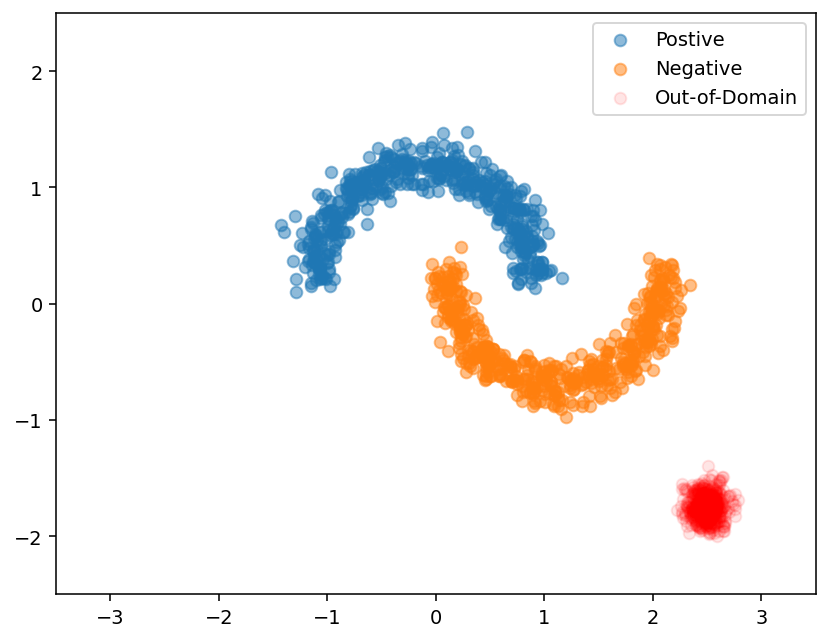

In [7]:
# Load the train, test and OOD datasets.
train_examples, train_labels = make_training_data(sample_size=500)
xx, yy, test_examples = make_testing_data()
ood_examples = make_ood_data(sample_size=500)

# Visualize
pos_examples = train_examples[train_labels == 0]
neg_examples = train_examples[train_labels == 1]

fig, ax = plt.subplots(1, 1, figsize=(7, 5.5))

ax.scatter(pos_examples[:, 0], pos_examples[:, 1], c="C0", alpha=0.5)
ax.scatter(neg_examples[:, 0], neg_examples[:, 1], c="C1", alpha=0.5)
ax.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

ax.legend(["Postive", "Negative", "Out-of-Domain"])

ax.set_ylim(DEFAULT_Y_RANGE)
ax.set_xlim(DEFAULT_X_RANGE)

plt.show()

## Evaluating the Trained Model

1. Run the training script to obtain the model:
```bash
$ cd experiments
$ python mwp.py
```
2. Move the best model from `outputs/YYYY-mm-dd/hh-mm-ss/models/name.ckpt` to `experiments/models/name.ckpt`

In [8]:
from hydra.utils import to_absolute_path
from pathlib import Path
from sngp_pytorch.models import LitBatchNorm1dRFGP
import hydra
from hydra.core.global_hydra import GlobalHydra

GlobalHydra.instance().clear()
hydra.initialize(config_path="config")
cfg = hydra.compose("mwp.yaml")

checkpoint = "make_moons-epoch=169-val_loss=0.00.ckpt"
model_saved = to_absolute_path(Path("models", checkpoint))
model = LitBatchNorm1dRFGP.load_from_checkpoint(model_saved)

model.eval()
model.model.update_covariance()

In [14]:
logits, variances = model(
    torch.from_numpy(test_examples).to(torch.float32),
    with_variance=True,
    mean_field=True,
)

probs = logits.detach().softmax(dim=-1).numpy()
variances = variances.numpy()
unc = np.sqrt(variances / variances.max())

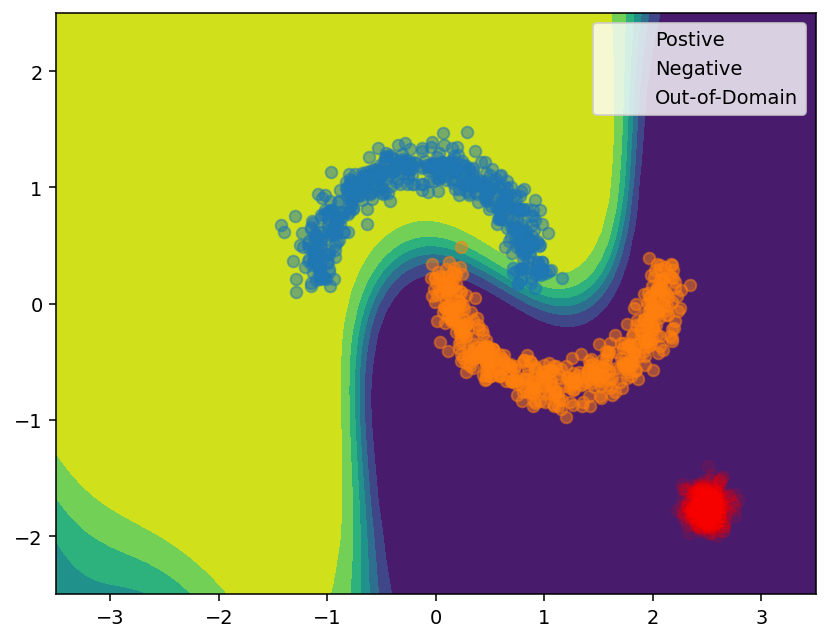

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5.5))

ax.contourf(
    xx,
    yy,
    probs[:, 0].reshape(DEFAULT_N_GRID, DEFAULT_N_GRID),
)

ax.scatter(pos_examples[:, 0], pos_examples[:, 1], c="C0", alpha=0.5)
ax.scatter(neg_examples[:, 0], neg_examples[:, 1], c="C1", alpha=0.5)
ax.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

ax.legend(["Postive", "Negative", "Out-of-Domain"])

ax.set_ylim(DEFAULT_Y_RANGE)
ax.set_xlim(DEFAULT_X_RANGE)

plt.show()

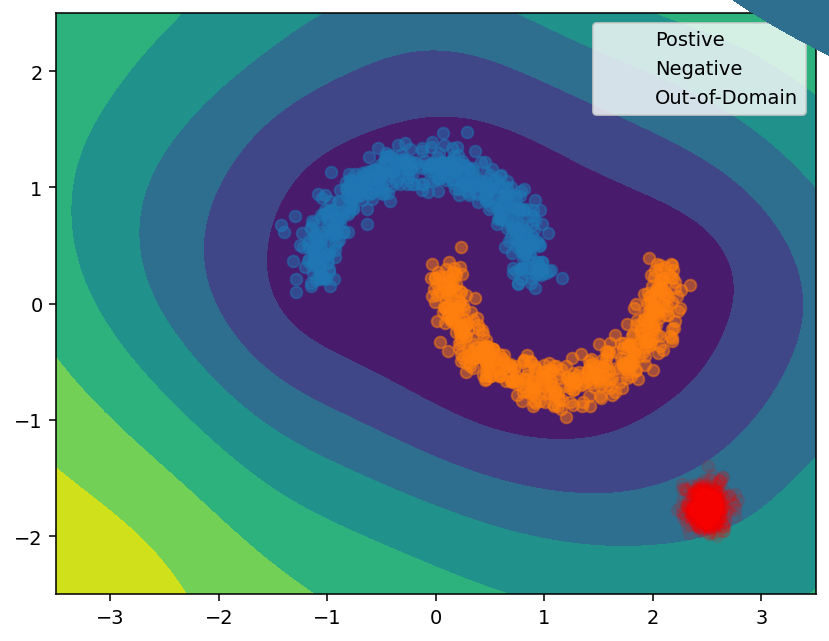

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5.5))

ax.contourf(xx, yy, unc.reshape(DEFAULT_N_GRID, DEFAULT_N_GRID))

ax.scatter(pos_examples[:, 0], pos_examples[:, 1], c="C0", alpha=0.5)
ax.scatter(neg_examples[:, 0], neg_examples[:, 1], c="C1", alpha=0.5)
ax.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

ax.legend(["Postive", "Negative", "Out-of-Domain"])

ax.set_ylim(DEFAULT_Y_RANGE)
ax.set_xlim(DEFAULT_X_RANGE)

plt.show()

## Imagenet

The below version of SNGP uses just a batch norm layer + random fourier features gaussian process on top of it.

1. Run the training script to obtain the model:
```bash
$ cd experiments
$ python mwp.py trainer=gpu data=imagenet model=large 
```
2. Move the best model from `outputs/YYYY-mm-dd/hh-mm-ss/models/name.ckpt` to `experiments/models/name.ckpt`

In [45]:
from hydra.utils import to_absolute_path
from pathlib import Path
from sngp_pytorch.models import LitBatchNorm1dRFGP
import hydra
from hydra.core.global_hydra import GlobalHydra

GlobalHydra.instance().clear()
hydra.initialize(config_path="config")
cfg = hydra.compose(
    "mwp.yaml", overrides=["trainer=gpu", "data=imagenet", "model=large"]
)

checkpoint = "EmbeddingsDataModule-epoch=03-val_loss=0.00.ckpt"
model_saved = to_absolute_path(Path("models", checkpoint))
model = LitBatchNorm1dRFGP.load_from_checkpoint(model_saved)

model.eval()
model.model.update_covariance()

In [46]:
from sngp_pytorch.datamodules.embeddings import NumpyDataset

imagenet_path = "/gpfs/gpfs0/k.fedyanin/space/imagenet_embeddings/val_embeddings.npy"

imagenet_o_path = (
    "/gpfs/gpfs0/k.fedyanin/space/imagenet_embeddings/ood_embeddings_imagenet_o.npy"
)
imagenet_r_path = (
    "/gpfs/gpfs0/k.fedyanin/space/imagenet_embeddings/ood_embeddings_imagenet_r.npy"
)

emb = NumpyDataset(np.load(imagenet_path, mmap_mode="c"))
emb_o = NumpyDataset(np.load(imagenet_o_path, mmap_mode="c"))
emb_r = NumpyDataset(np.load(imagenet_r_path, mmap_mode="c"))

In [47]:
from torch.utils.data import DataLoader
from tqdm.auto import tqdm


def get_uncertainty(embeddings, model, batch_size=1024, verbose=True):
    dataloader = DataLoader(embeddings, batch_size=batch_size)
    uncs = []

    for (X,) in tqdm(dataloader, total=len(dataloader), disable=not verbose):
        _, unc = model(X, with_variance=True)
        uncs.append(unc ** 0.5)

    uncs = torch.concat(uncs)
    return uncs.detach().cpu().numpy()

In [49]:
ues_all_path = to_absolute_path(Path("data", "ues_all.npz"))
try:
    ues_all = np.load(ues_all_path)
except FileNotFoundError:
    ues_all = {}
    for name, emb_tmp in zip(["ues", "ood_ues_o", "ood_ues_r"], [emb, emb_o, emb_r]):
        ues_all[name] = get_uncertainty(emb_tmp, model)
    np.savez(ues_all_path, **ues_all)

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

OOD ROC AUC 0.699
OOD ROC AUC 0.525


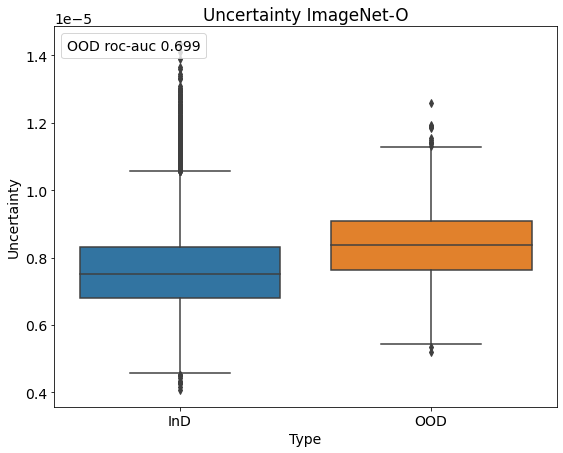

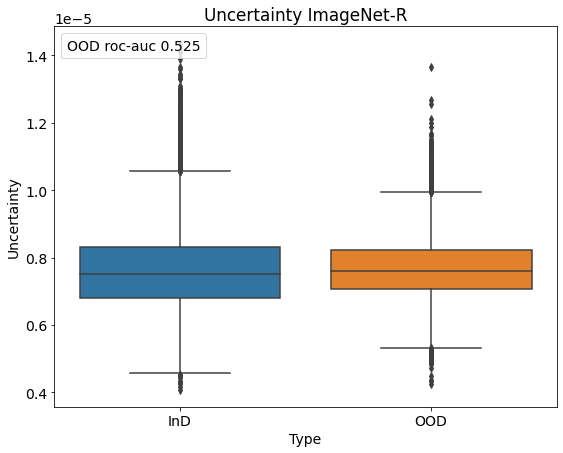

In [50]:
from metrics import uncertainty_plot

for postfix in ["o", "r"]:
    uncertainty_plot(
        ues_all["ues"],
        ues_all[f"ood_ues_{postfix}"],
        directory="data",
        file_name=f"imagenet_{postfix}",
        title=f"Uncertainty ImageNet-{postfix.upper()}",
    )